In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train_losses, test_losses = [], []

data = pd.read_excel('../Dataset/complemented_dataset.xlsx')

X = data.drop(columns=['Race'])
y = data['Race']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

def one_hot_encode(labels, num_classes=None):
    if num_classes is None:
        num_classes = len(np.unique(labels))
    return np.eye(num_classes)[labels - labels.min()]

train_Y_one_hot = one_hot_encode(train_y)
test_Y_one_hot = one_hot_encode(test_y)

input_size = train_X.shape[1]
hidden_size = 750
output_size = train_Y_one_hot.shape[1]

np.random.seed(20)
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((hidden_size,))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((output_size,))

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def forward(X):
    z1 = np.dot(X, W1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    return z1, a1, z2, a2

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

def backward(X, y_true, z1, a1, a2):
    m = y_true.shape[0]
    dz2 = a2 - y_true
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0) / m
    
    da1 = np.dot(dz2, W2.T)
    dz1 = da1 * relu_derivative(z1)
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0) / m
    
    return dW1, db1, dW2, db2

epochs, batch_size, learning_rate = 900, 15, 0.01

def train(X, y, epochs=epochs, batch_size=batch_size, learning_rate=learning_rate):
    global W1, b1, W2, b2
    m = X.shape[0]
    for epoch in range(epochs):
        for i in range(0, m, batch_size):
            X_batch, y_batch = X[i:i+batch_size], y[i:i+batch_size]
            z1, a1, z2, a2 = forward(X_batch)
            loss = compute_loss(y_batch, a2)
            
            dW1, db1, dW2, db2 = backward(X_batch, y_batch, z1, a1, a2)
            
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2
        train_loss, train_accuracy = evaluate(X, y)
        test_loss, test_accuracy = evaluate(test_X.values, test_Y_one_hot)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                  f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

def evaluate(X, y):
    _, _, _, y_pred = forward(X)
    loss = compute_loss(y, y_pred)
    accuracy_val = accuracy(np.argmax(y, axis=1), np.argmax(y_pred, axis=1))
    return loss, accuracy_val

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def plot_losses():
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.show()


train(train_X.values, train_Y_one_hot)

final_train_loss, final_train_accuracy = evaluate(train_X.values, train_Y_one_hot)
final_test_loss, final_test_accuracy = evaluate(test_X.values, test_Y_one_hot)
print(f'Final Train Accuracy: {final_train_accuracy * 100:.2f}%')
print(f'Final Test Accuracy: {final_test_accuracy * 100:.2f}%')


Epoch 0, Train Loss: 2.6966, Train Accuracy: 0.13%, Test Loss: 2.6964, Test Accuracy: 0.13%
Epoch 10, Train Loss: 2.5052, Train Accuracy: 0.16%, Test Loss: 2.4995, Test Accuracy: 0.17%
Epoch 20, Train Loss: 2.4598, Train Accuracy: 0.18%, Test Loss: 2.4512, Test Accuracy: 0.19%


KeyboardInterrupt: 

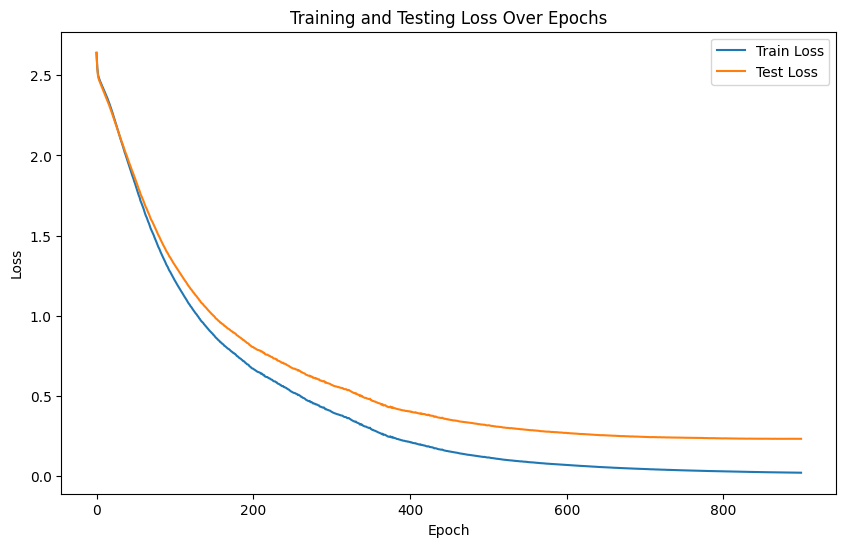

In [14]:
plot_losses()

In [16]:
def misclassified_races(true_labels, predicted_labels, class_names):
    misclassified = true_labels != predicted_labels
    misclassified_race_names = class_names[misclassified]
    return misclassified_race_names.value_counts()

def plot_misclassified_pie(misclassified_counts):
    plt.figure(figsize=(8, 8))
    misclassified_counts.plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False, colormap='viridis')
    plt.title('Misclassified Races')
    plt.ylabel('')
    plt.show()

_, _, _, test_predictions = forward(test_X.values)
test_predicted_classes = np.argmax(test_predictions, axis=1)
true_test_classes = np.argmax(test_Y_one_hot, axis=1)
misclassified_counts = misclassified_races(true_test_classes, test_predicted_classes, test_y.reset_index(drop=True))

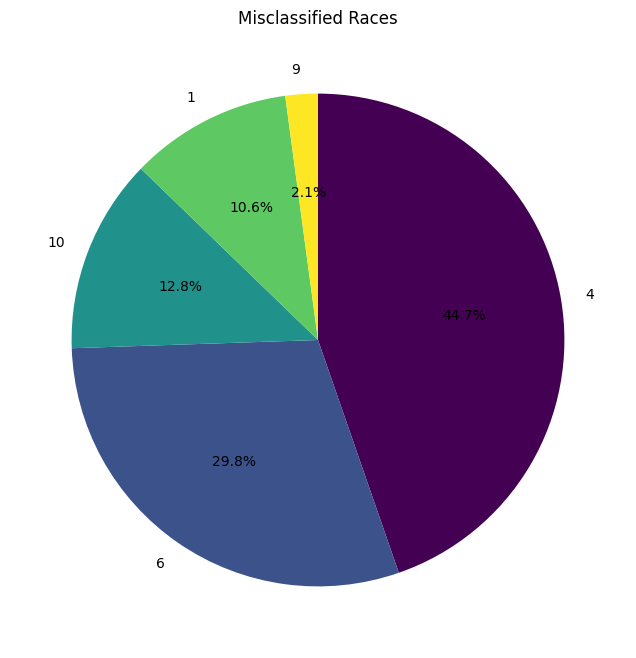

In [17]:
plot_misclassified_pie(misclassified_counts)